In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error

color_pal = sns.color_palette()

# Override the default linewidth and markersize
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 5

from datetime import datetime
import utils

In [7]:
ROOT_DIR = '/home/forhad/Desktop/exam/Hugging-face.yt/time-series/'
TARGET_TEST_CUTOFF_DATE = '01-01-2016'

In [8]:
df = pd.read_csv(ROOT_DIR + 'PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

In [9]:
df.tail()

,PJME_MW
Datetime,
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0
2018-01-01 23:00:00,40164.0
2018-01-02 00:00:00,38608.0


### Seasonal Decompose of Time series with statsmodel

seasonal_decompose is a function that decomposes a time series into three main components: trend, seasonal, and residual (or irregular). The decomposition is based on the assumption that the observed time series is a product (multiplicative model) or a sum (additive model) of these three components. This function is particularly useful for understanding the underlying structure of a time series and can help you identify patterns, trends, and seasonality in the data.

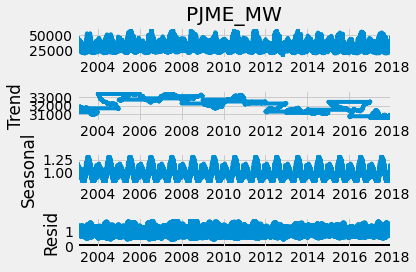

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose

ANNUAL_PERIOD = 365*24
mult_decomp = seasonal_decompose(df['PJME_MW'], model='multiplicative', extrapolate_trend='freq', period=ANNUAL_PERIOD)
mult_decomp.plot()
plt.show()

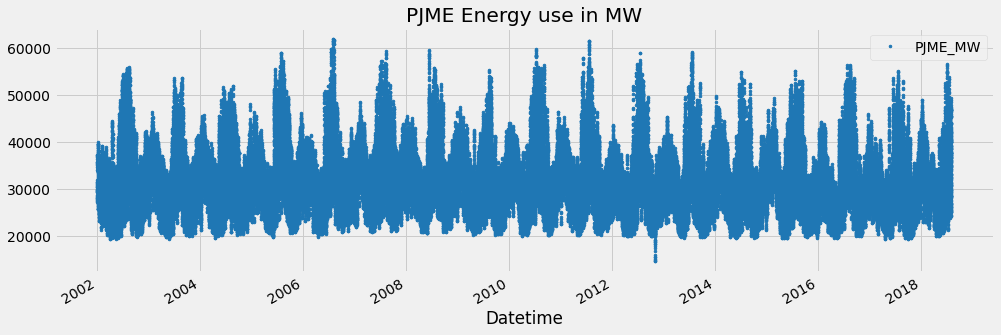

In [14]:
df.plot(style = '.',
       figsize = (15,5),
       color = color_pal[0],
       title = 'PJME Energy use in MW')

plt.show()

In [15]:
train = df.loc[df.index < TARGET_TEST_CUTOFF_DATE]
test = df.loc[df.index >= TARGET_TEST_CUTOFF_DATE]

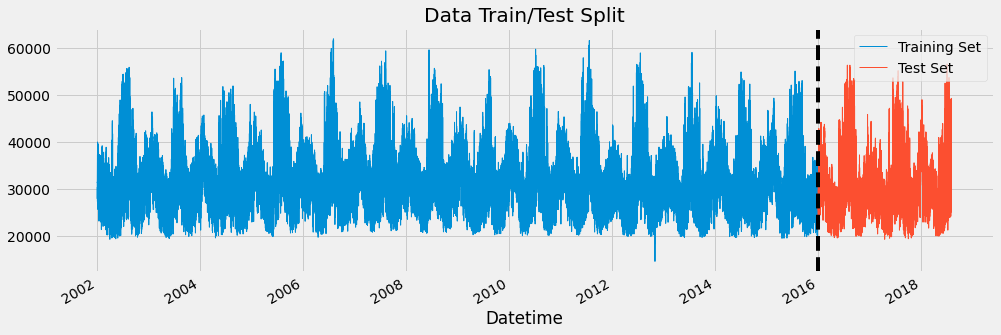

In [16]:
utils.plot_train_test_split(df, TARGET_TEST_CUTOFF_DATE)


#### A single week data looks like:

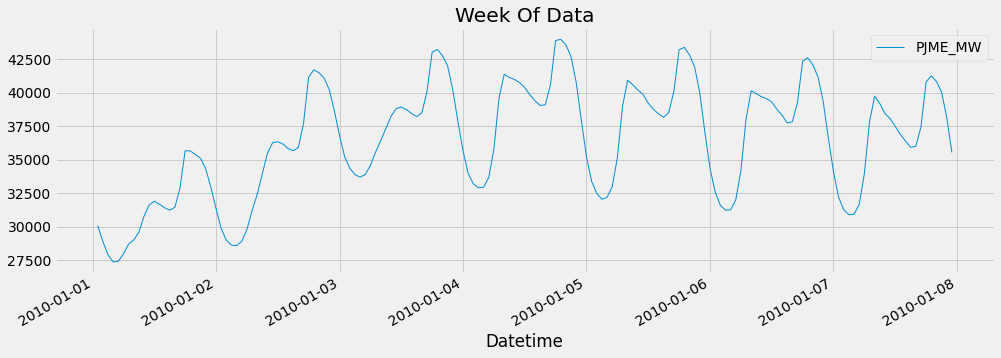

In [17]:
utils.plot_week_of_data(df, '01-01-2010', '01-08-2010')


In [18]:
df = utils.create_time_series_features(df)


In [19]:
df.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,31,1
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,31,1
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,31,1
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365,31,1
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365,31,1


#### This function generates a 2x2 grid of boxplots to visualize the time series data.
###### '( this function assumes that the input dataframe has columns named dayofweek, month, hour, and year)'

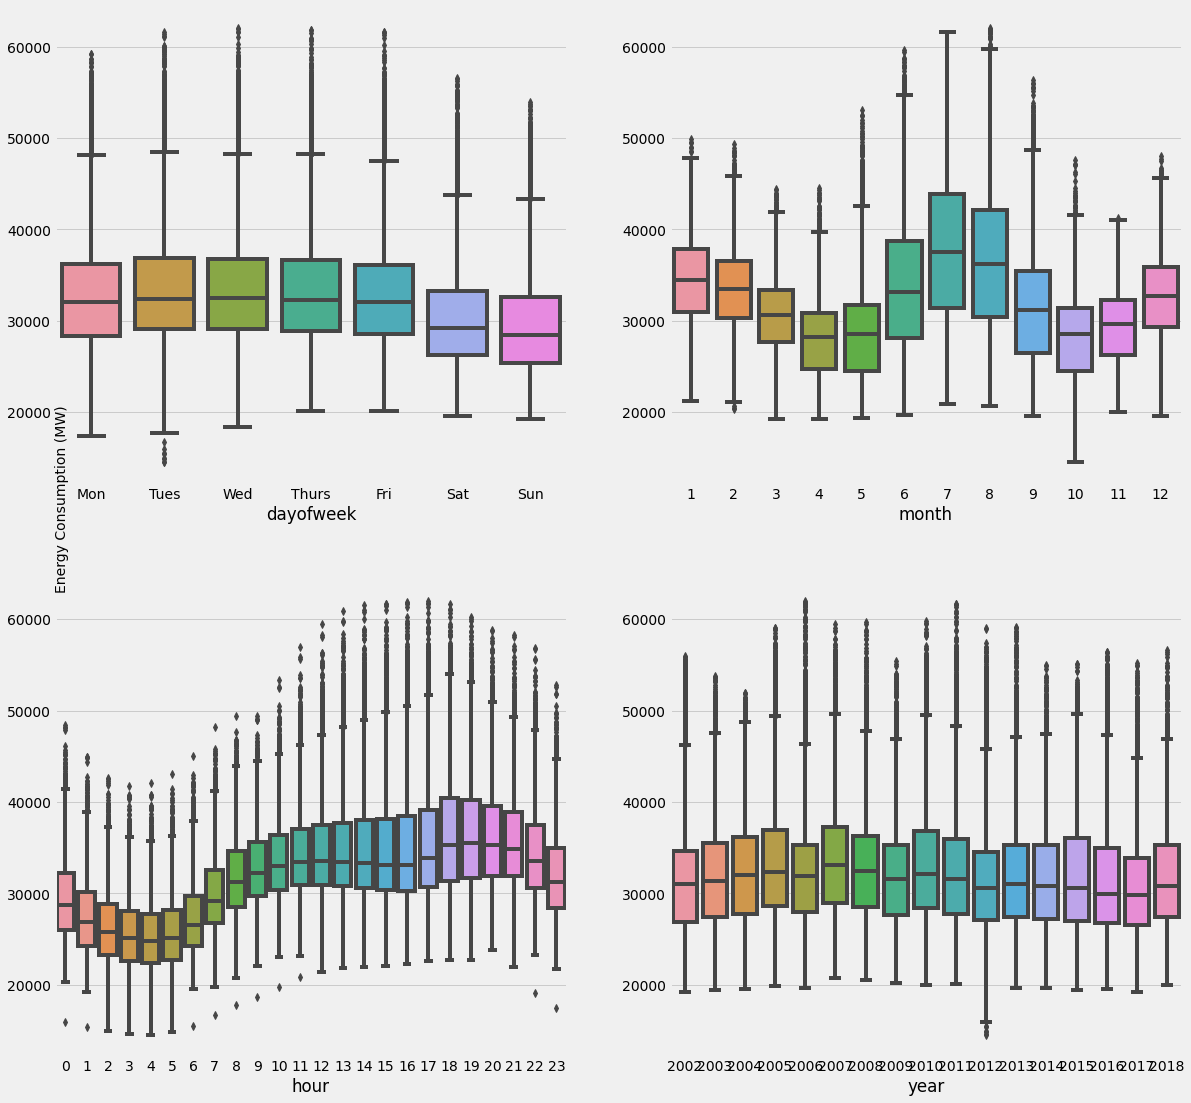

In [20]:
def plot_time_series(df, dependent_var):
 
    
    # Assert if the required columns are present in the dataframe
    assert 'dayofweek' in df.columns, "Input dataframe must have a 'dayofweek' column"
    assert 'month' in df.columns, "Input dataframe must have a 'month' column"
    assert 'hour' in df.columns, "Input dataframe must have an 'hour' column"
    assert 'year' in df.columns, "Input dataframe must have a 'year' column"
    assert dependent_var in df.columns, f"Input dataframe must have a '{dependent_var}' column"
 
    # figure with a 2x2 grid
    fig, axes = plt.subplots(2, 2, figsize=(18,18))
    
    # Day of Week
    dow_labels = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
    g = sns.boxplot(x=df.dayofweek, y=df[dependent_var], ax=axes[0][0])
    g.set_xticklabels(dow_labels)
    g.set_ylabel('')
    
    # Month of Year
    g = sns.boxplot(x=df.month, y=df[dependent_var], ax=axes[0][1])
    g.set_ylabel('')
    
    # Hour of Day
    g = sns.boxplot(x=df.hour, y=df[dependent_var], ax=axes[1][0])
    g.set_ylabel('')
    
    # Year
    g = sns.boxplot(x=df.year, y=df[dependent_var], ax=axes[1][1])
    g.set_ylabel('')
    
    # Set the title for the y-axis
    fig.text(0.08, 0.5, 'Energy Consumption (MW)', va='center', rotation='vertical')
    
    # Display the plot
    plt.show()

plot_time_series(df, 'PJME_MW')

#### Analysis with seasonal plot

In [21]:
df_dup = df.copy()
years_months = df_dup.groupby(['year', 'month']).mean().reset_index()
years_months.head()

,year,month,PJME_MW,hour,dayofweek,quarter,dayofyear,dayofmonth,weekofyear
0,2002,1,31075.399731,11.515478,2.905787,1.0,16.020188,16.020188,2.873486
1,2002,2,30239.166667,11.500000,3.000000,1.0,45.500000,14.500000,7.071429
2,2002,3,28875.256720,11.500000,3.193548,1.0,75.000000,16.000000,11.258065
3,2002,4,28534.731572,11.511822,2.828929,2.0,105.511822,15.511822,15.668985
4,2002,5,28073.653226,11.500000,3.000000,2.0,136.000000,16.000000,20.000000


##### generating a line plot of the mean monthly energy consumption for each year.

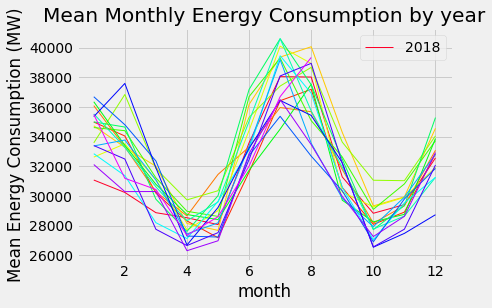

In [22]:
import matplotlib.pyplot as plt

def plot_monthly_consumption(df, dependent_var):
 
    
    assert 'year' in df.columns, "Input dataframe must have a 'year' column"
    assert 'month' in df.columns, "Input dataframe must have a 'month' column"
    assert dependent_var in df.columns, f"Input dataframe must have a '{dependent_var}' column"
   
    df_copy = df.copy()

    # Computing the mean for each group
    year_group = df_copy.groupby(['year', 'month']).mean().reset_index()
    
    years = df_copy['year'].unique()
    NUM_COLORS = len(years)

    cm = plt.get_cmap('gist_rainbow')
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

    for i, y in enumerate(years):
        df_copy = year_group[year_group['year'] == y]
        plt.plot(df_copy['month'], df_copy[dependent_var], linewidth=1, markersize=5)
    
    plt.title('Mean Monthly Energy Consumption by year')
    plt.xlabel('month')
    plt.ylabel('Mean Energy Consumption (MW)')
    plt.legend(df_copy.year.unique())
    plt.show()

plot_monthly_consumption(df, 'PJME_MW')

In [25]:
train.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [26]:
train = utils.create_time_series_features(train)
test = utils.create_time_series_features(test)
train.head(2)

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,31,1
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,31,1


In [27]:
train['weekofyear'] = train['weekofyear'].astype('int32')
test['weekofyear'] = test['weekofyear'].astype('int32')

In [28]:
time_series_features = ['dayofyear', 'hour', 'dayofweek', 'weekofyear', 'quarter', 'month', 'year']
time_series_target = 'PJME_MW'

X_train = train[time_series_features]
y_train = train[time_series_target]

X_test = test[time_series_features]
y_test = test[time_series_target]

In [29]:
X_train.head(2)


,dayofyear,hour,dayofweek,weekofyear,quarter,month,year
Datetime,,,,,,,
2002-12-31 01:00:00,365,1,1,1,4,12,2002
2002-12-31 02:00:00,365,2,1,1,4,12,2002


In [30]:
y_test.head()

Datetime
2016-01-01 00:00:00    26686.0
2016-12-31 01:00:00    29627.0
2016-12-31 02:00:00    28744.0
2016-12-31 03:00:00    28274.0
2016-12-31 04:00:00    28162.0
Name: PJME_MW, dtype: float64

In [31]:
model = utils.train_xgb_regressor(X_train, y_train, X_test, y_test, use_gpu=True)


[17:30:02] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:30:02] WARNING: ../src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:32564.27930	validation_1-rmse:31495.27930
[100]	validation_0-rmse:12398.51172	validation_1-rmse:11560.13574
[200]	validation_0-rmse:5402.51465	validation_1-rmse:5173.74561
[300]	validation_0-rmse:3371.32349	validation_1-rmse:3961.95947
[400]	validation_0-rmse:2880.37207	validation_1-rmse:3938.93555
[500]	validation_0-rmse:2717.47144	validation_1-rmse:4008.21680
[600]	validation_0-rmse:2625.97925	validation_1-rmse:4049.69189
[700]	validation_0-rmse:2560.33838	validation_1-rmse:4084.8

#### Ploting important features

In [42]:
from xgboost import plot_importance
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

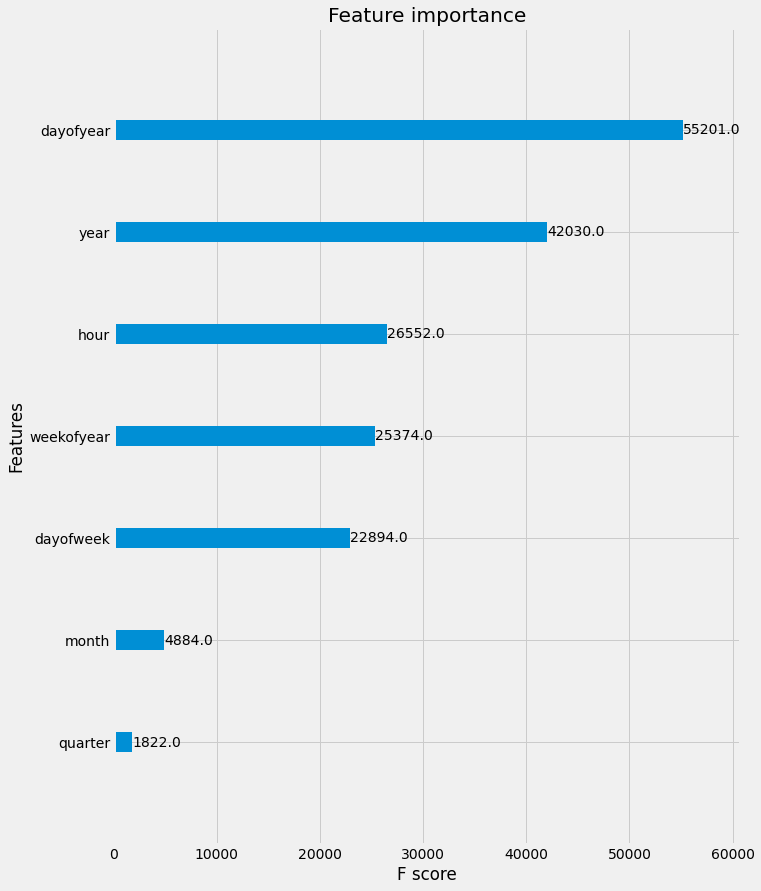

In [43]:
plot_features(model, (10,14))

In [44]:
test['prediction'] = model.predict(X_test)

df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

df.tail(2)

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction
Datetime,,,,,,,,,,
2018-08-02 23:00:00,38500.0,23,3,3,8,2018,214,2,31,37872.238281
2018-08-03 00:00:00,35486.0,0,4,3,8,2018,215,3,31,34726.371094


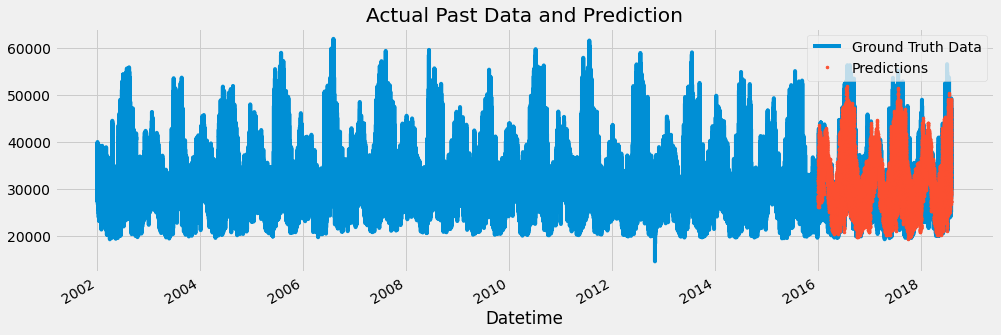

In [45]:
ax = df[['PJME_MW']].plot(figsize=(15, 5))

df['prediction'].plot(ax=ax, style='.')
plt.legend(['Ground Truth Data', 'Predictions'])
ax.set_title('Actual Past Data and Prediction')
plt.show()

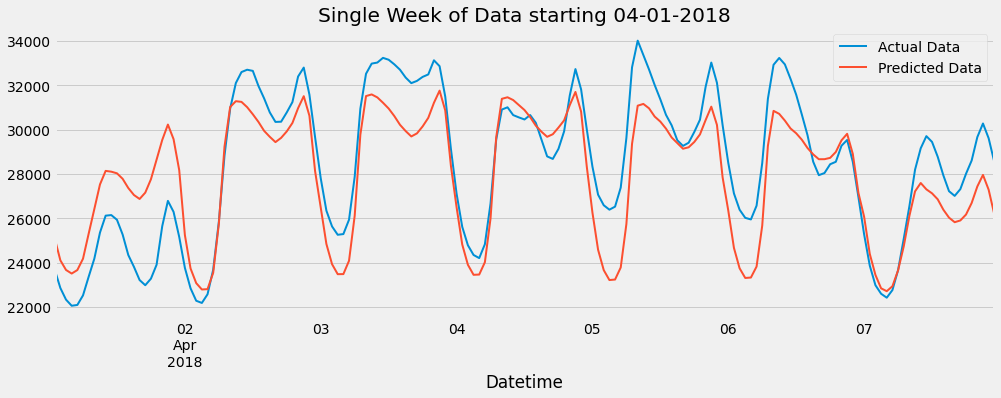

In [46]:
data = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]

# plot the actual and predicted data
ax = data['PJME_MW'].plot(figsize=(15, 5), title='Single Week of Data starting 04-01-2018', linewidth=2, markersize=5)

data['prediction'].plot(style='-', linewidth=2, markersize=5)

plt.legend(['Actual Data', 'Predicted Data'])
plt.show()

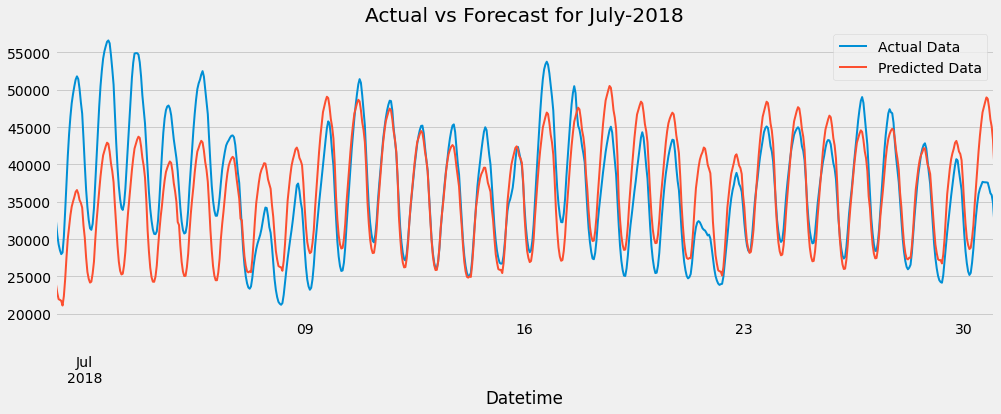

In [47]:
data = df.loc[(df.index > '07-01-2018') & (df.index < '07-31-2018')]

# plot the actual portion
ax = data['PJME_MW'].plot(figsize=(15, 5), title='Actual vs Forecast for July-2018', linewidth=2, markersize=5)

# plot the predicted portion
data['prediction'].plot(style='-', linewidth=2, markersize=5)

plt.legend(['Actual Data', 'Predicted Data'])
plt.show()

#### RMSE

SyntaxError: invalid syntax (<ipython-input-51-0ab07159617f>, line 1)

In [48]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 4434.26


In [49]:
test['error'] = np.abs(test[time_series_target] - test['prediction'])

test['date'] = test.index.date

test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2017-02-20    13988.304362
2017-12-31    13190.062907
2017-02-25    13012.917643
2017-02-19    12939.074870
2017-12-29    12894.260173
2017-02-24    12771.550944
2017-12-28    12685.158203
2016-08-13    12556.891683
2018-02-20    12354.126790
2018-01-01    11720.412354
Name: error, dtype: float64